参考：[机器学习实战教程（十三）：树回归基础篇之CART算法与树剪枝](https://cuijiahua.com/blog/2017/12/ml_13_regtree_1.html)

一、前言
本篇文章将会讲解CART算法的实现和树的剪枝方法，通过测试不同的数据集，学习CART算法和树剪枝技术。

二、将CART（Classification And Regression Trees）算法用于回归
在之前的文章，我们学习了决策树的原理和代码实现，使用使用决策树进行分类。决策树不断将数据切分成小数据集，直到所有目标标量完全相同，或者数据不能再切分为止。决策树是一种贪心算法，它要在给定时间内做出最佳选择，但不关心能否达到全局最优。

1、ID3算法的弊端
回忆一下，决策树的树构建算法是ID3。ID3的做法是每次选取当前最佳的特征来分割数据，并按照该特征的所有可能取值来切分。也就是说，如果一个特征有4种取值，那么数据将被切分成4份。一旦按某特征切分后，该特征在之后的算法执行过程中将不会再起作用，所以有观点认为这种切分方式过于迅速。

除了切分过于迅速外，ID3算法还存在另一个问题，它不能直接处理连续型特征。只有事先将连续型特征离散化，才能在ID3算法中使用。但这种转换过程会破坏连续型变量的内在特性。

2、CART算法
与ID3算法相反，CART算法正好适用于连续型特征。CART算法使用二元切分法来处理连续型变量。而使用二元切分法则易于对树构建过程进行调整以处理连续型特征。具体的处理方法是：如果特征值大于给定值就走左子树，否则就走右子树。

CART算法有两步：

决策树生成：递归地构建二叉决策树的过程，基于训练数据集生成决策树，生成的决策树要尽量大；自上而下从根开始建立节点，在每个节点处要选择一个最好的属性来分裂，使得子节点中的训练集尽量的纯。不同的算法使用不同的指标来定义"最好"：
决策树剪枝：用验证数据集对已生成的树进行剪枝并选择最优子树，这时损失函数最小作为剪枝的标准。
决策树剪枝我们先不管，我们看下决策树生成。

在决策树的文章中，我们先根据信息熵的计算找到最佳特征切分数据集构建决策树。CART算法的决策树生成也是如此，实现过程如下：

使用CART算法选择特征
根据特征切分数据集合
构建树

3、根据特征切分数据集合
我们先找软柿子捏，CART算法这里涉及到算法，实现起来复杂些，我们先挑个简单的，即根据特征切分数据集合。编写代码如下：

In [1]:
#-*- coding:utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import types

In [2]:
'''
函数功能：根据特征切分数据集合
参数说明：
    dataSet：数据集合
    feature：待切分的特征
    value：该特征的值
返回：
    mat0：切分的数据集合0
    mat1：切分的数据集合1
'''
def binSplitDataSet(dataSet,feature,value):
    # np.nonzero() 输出满足值为非0数的索引
    mat0 = dataSet[np.nonzero(dataSet[:,feature] > value)[0],: ]
    #print(np.nonzero(dataSet[:,feature] > value)[0]) --->[1]
    mat1 = dataSet[np.nonzero(dataSet[:,feature] <= value)[0],: ]
    return mat0,mat1

In [3]:
# 测试binSplitDataSet函数
if __name__ =='__main__':
    testMat = np.mat(np.eye(4))
    mat0,mat1 = binSplitDataSet(testMat,1,0.5)
    print('原始集合：\n',testMat)
    print('mat0:\n',mat0)
    print('mat1:\n',mat1)    

原始集合：
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
mat0:
 [[0. 1. 0. 0.]]
mat1:
 [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


我们先创建一个单位矩阵，然后根据切分规则，对数据矩阵进行切分。可以看到binSplitDataSet函数根据特定规则，对数据矩阵进行切分。

现在OK了，我们已经可以根据特征和特征值对数据进行切分了，mat0存放的是大于指定特征值的矩阵，mat1存放的是小于指定特征值的矩阵。接下来，我们就看看如何使用CART算法选择最佳分类特征。

In [4]:
'''
函数功能：加载数据
参数说明：
    fileMame: 文件名
返回：
    数据矩阵
'''
def loadDataSet(fileName):
    dataMat = []
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float, curLine))                    #转化为float类型
        dataMat.append(fltLine)
    return dataMat

In [25]:
'''
函数功能：绘制数据集
参数说明：
    filename：文件名
返回：
    无
'''
def plotDataSet(filename):
    dataMat = loadDataSet(filename)                                        #加载数据集
    n = len(dataMat)                                                    #数据个数
    xcord = []; ycord = []                                                #样本点
    for i in range(n):
        if filename == 'ex0.txt':
            xcord.append(dataMat[i][1]) 
            ycord.append(dataMat[i][2])                              #样本点
        else:
            xcord.append(dataMat[i][0]) 
            ycord.append(dataMat[i][1]) 
    fig = plt.figure()
    ax = fig.add_subplot(111)                                            #添加subplot
    ax.scatter(xcord, ycord, s = 20, c = 'blue',alpha = .5)                #绘制样本点
    plt.title('DataSet')                                                #绘制title
    plt.xlabel('X')
    plt.show()

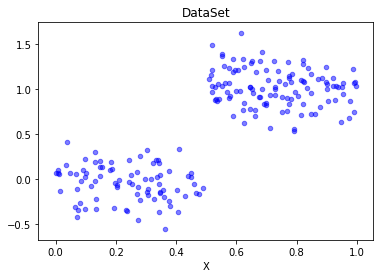

In [22]:
plotDataSet('ex00.txt')

In [7]:
'''
函数功能：生成叶节点
参数说明：
    dataSet：数据集合
返回：
    目标变量的均值
'''
def regLeaf(dataSet):
    return np.mean(dataSet[:,-1])

In [8]:
'''
函数功能：误差估计函数
参数说明：
    dataSet：数据集合
返回：
    目标变量的总方差
'''
def regErr(dataSet):
    return np.var(dataSet[:,-1]) * np.shape(dataSet)[0]

In [12]:
'''
函数功能：找到数据的最佳二分切分方式
参数说明：
    dataSet: 数据集
    leafType：生成叶节点
    errType： 误差估计函数
    ops：用户定义的参数构成的元祖
返回：
    bestIndex：最佳切分特征
    bestValue：最佳特征值
'''
def chooseBestSplit(dataSet,leafType = regLeaf,errType = regErr,ops = (1,4)):
    tolS = ops[0] # tolS允许的误差下降值
    tolN = ops[1] # tolN切分的最少样本数
    #  如果当前所有值相等，则退出。（根据set集合的特性）
    if len(set(dataSet[:,-1].T.tolist()[0])) == 1:
        return None,leafType(dataSet)
    
    m,n = np.shape(dataSet) # 数据集合的行数和列数   
    S = errType(dataSet) # 默认最后一个特征为最佳切分特征，计算其误差估计
    
    bestS = float('inf') # 最佳误差，初始为最大值
    bestIndex = 0 # 最佳切分特征 索引值
    bestValue = 0 #  最佳切分特征
    
    # 遍历所有特征
    for featIndex  in range(n-1):
        # 遍历所有特征值
        for splitVal in set(dataSet[:,featIndex].T.A.tolist()[0]):
            # 根据特征和特征值切分数据集
            mat0 , mat1 = binSplitDataSet(dataSet,featIndex,splitVal)
            # 如果划分的数据数少于用户设定的tolN，则退出
            if(np.shape(mat0)[0]<tolN) or (np.shape(mat1)[0]<tolN):
                continue
            # 计算划分后的数据集的误差估计
            newS = errType(mat0) + errType(mat1)
            
            # 如果误差估计更小，则更新特征索引值和特征值
            if newS < bestS:
                bestIndex = featIndex
                bestValue = splitVal
                bestS = newS
    # 如果误差减小不大则退出
    if (S - bestS) < tolS:
        return None,leafType(dataSet)
    
    # 根据最佳的切分特征和特征值切分数据集合
    mat0 , mat1 = binSplitDataSet(dataSet,bestIndex,bestValue)
    
    #  如果划分的数据数少于用户设定的tolN，则退出
    if(np.shape(mat0)[0] < tolN) or (np.shape(mat1)[0]<tolN):
        return None,leafType(dataSet)
    
    # 返回最佳切分特征索引和特征值
    return bestIndex , bestValue

In [13]:
'''
函数功能：回归树构建函数
参数说明：
    dataSet: 数据集
    leafType：生成叶节点
    errType： 误差估计函数
    ops：用户定义的参数构成的元祖
返回：
    retTree：构建的回归树
'''
def createTree(dataSet,leafType = regLeaf,errType = regErr,ops=(1,4)):
    # 选择最佳切分特征
    feat , val = chooseBestSplit(dataSet,leafType,errType,ops)
    #如果没有特征，则返回特征值
    if feat == None:
        return val
    # 回归树
    retTree = {}
    retTree['spInd'] = feat # 特征索引
    retTree['spVal'] = val  # 特征值
    
    # 根据特征索引和特征值将该特征一分为二
    lSet , rSet = binSplitDataSet(dataSet,feat,val)
    # 创建左子树和右子树
    retTree['left'] = createTree(lSet,leafType,errType,ops)
    retTree['right'] = createTree(rSet,leafType,errType,ops)
    return retTree

In [14]:
if __name__ == '__main__':
    myDat = loadDataSet('ex00.txt')
    myMat = np.mat(myDat)
    print(createTree(myMat))

{'spInd': 0, 'spVal': 0.48813, 'left': 1.0180967672413792, 'right': -0.04465028571428572}


从上图可知，这棵树只有两个叶结点。

我们换一个复杂一点的数据集，分段常数数据集。

In [15]:
dataSet = loadDataSet('ex0.txt')

In [18]:
dataSet[:10]

[[1.0, 0.409175, 1.88318],
 [1.0, 0.182603, 0.063908],
 [1.0, 0.663687, 3.042257],
 [1.0, 0.517395, 2.305004],
 [1.0, 0.013643, -0.067698],
 [1.0, 0.469643, 1.662809],
 [1.0, 0.725426, 3.275749],
 [1.0, 0.39435, 1.118077],
 [1.0, 0.50776, 2.095059],
 [1.0, 0.237395, 1.181912]]

第一列的数据都是1.0，为了可视化方便，我们将第1列作为x轴数据，第2列作为y轴数据。对数据进行可视化

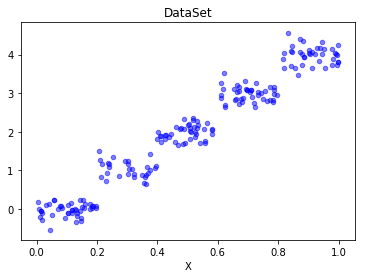

In [26]:
plotDataSet('ex0.txt')

可以看到，这个数据集是分段的。我们针对此数据集创建回归树。代码同上，运行结果如下图所示：

In [24]:
if __name__ == '__main__':
    myDat = loadDataSet('ex0.txt')
    myMat = np.mat(myDat)
    print(createTree(myMat))

{'spInd': 1, 'spVal': 0.39435, 'left': {'spInd': 1, 'spVal': 0.582002, 'left': {'spInd': 1, 'spVal': 0.797583, 'left': 3.9871632, 'right': 2.9836209534883724}, 'right': 1.980035071428571}, 'right': {'spInd': 1, 'spVal': 0.197834, 'left': 1.0289583666666666, 'right': -0.023838155555555553}}


可以看到，该数的结构中包含5个叶结点。

现在为止，已经完成回归树的构建，但是需要某种措施来检查构建过程是否得当。这个技术就是剪枝（tree pruning）技术。

一棵树如果结点过多，表明该模型可能对数据进行了“过拟合”。

通过降低树的复杂度来避免过拟合的过程称为剪枝（pruning）。上小节我们也已经提到，设置tolS和tolN就是一种预剪枝操作。另一种形式的剪枝需要使用测试集和训练集，称作后剪枝（postpruning）。本节将分析后剪枝的有效性，但首先来看一下预剪枝的不足之处。

1、预剪枝
预剪枝有一定的局限性，比如我们现在使用一个新的数据集。

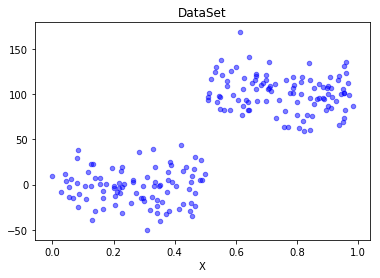

In [27]:
plotDataSet('ex2.txt')

可以看到，对于这个数据集与我们使用的第一个数据集很相似，但是区别在于y的数量级差100倍，数据分布相似，因此构建出的树应该也是只有两个叶结点。但是我们使用默认tolS和tolN参数创建树，你会发现运行结果如下所示：

In [28]:
if __name__ == '__main__':
    myDat = loadDataSet('ex2.txt')
    myMat = np.mat(myDat)
    print(createTree(myMat))

{'spInd': 0, 'spVal': 0.499171, 'left': {'spInd': 0, 'spVal': 0.729397, 'left': {'spInd': 0, 'spVal': 0.952833, 'left': {'spInd': 0, 'spVal': 0.958512, 'left': 105.24862350000001, 'right': 112.42895575000001}, 'right': {'spInd': 0, 'spVal': 0.759504, 'left': {'spInd': 0, 'spVal': 0.790312, 'left': {'spInd': 0, 'spVal': 0.833026, 'left': {'spInd': 0, 'spVal': 0.944221, 'left': 87.3103875, 'right': {'spInd': 0, 'spVal': 0.85497, 'left': {'spInd': 0, 'spVal': 0.910975, 'left': 96.452867, 'right': {'spInd': 0, 'spVal': 0.892999, 'left': 104.825409, 'right': {'spInd': 0, 'spVal': 0.872883, 'left': 95.181793, 'right': 102.25234449999999}}}, 'right': 95.27584316666666}}, 'right': {'spInd': 0, 'spVal': 0.811602, 'left': 81.110152, 'right': 88.78449880000001}}, 'right': 102.35780185714285}, 'right': 78.08564325}}, 'right': {'spInd': 0, 'spVal': 0.640515, 'left': {'spInd': 0, 'spVal': 0.666452, 'left': {'spInd': 0, 'spVal': 0.706961, 'left': 114.554706, 'right': {'spInd': 0, 'spVal': 0.698472, '

可以看到，构建出的树有很多叶结点。产生这个现象的原因在于，停止条件tolS对误差的数量级十分敏感。如果在选项中花费时间并对上述误差容忍度取平均值，或许也能得到仅有两个叶结点组成的树：

In [30]:
if __name__ == '__main__':
    myDat = loadDataSet('ex2.txt')
    myMat = np.mat(myDat)
    print(createTree(myMat,ops=(10000,4)))

{'spInd': 0, 'spVal': 0.499171, 'left': 101.35815937735848, 'right': -2.637719329787234}


可以看到，将参数tolS修改为10000后，构建的树就是只有两个叶结点。然而，显然这个值，需要我们经过不断测试得来，显然通过不断修改停止条件来得到合理结果并不是很好的办法。事实上，我们常常甚至不确定到底需要寻找什么样的结果。因为对于一个很多维度的数据集，你也不知道构建的树需要多少个叶结点。

可见，预剪枝有很大的局限性。接下来，我们讨论后剪枝，即利用测试集来对树进行剪枝。由于不需要用户指定参数，后剪枝是一个更理想化的剪枝方法。

## 2、后剪枝
使用后剪枝方法需要将数据集分成测试集和训练集。首先指定参数，使得构建出的树足够大、足够复杂，便于剪枝。接下来从上而下找到叶结点，用测试集来判断这些叶结点合并是否能降低测试集误差。如果是的话就合并。

为了演示后剪枝，我们使用ex2.txt文件作为训练集，而使用的新数据集ex2test.txt文件作为测试集。

现在我们使用ex2.txt训练回归树，然后利用ex2test.txt对回归树进行剪枝。我们需要创建三个函数isTree()、getMean()、prune()。
其中isTree()用于测试输入变量是否是一棵树，返回布尔类型的结果。换句话说，该函数用于判断当前处理的结点是否是叶结点。

第二个函数getMean()是一个递归函数，它从上往下遍历树直到叶结点为止。如果找到两个叶结点则计算它们的平均值。该函数对树进行塌陷处理（即返回树平均值）。

而第三个函数prune()则为后剪枝函数。

编写代码如下：

In [31]:
'''
函数功能：判断测试输入的变量是否是一棵树
参数说明：
    obj：测试对象
返回：
    True or False
'''
def isTree(obj):
    return (type(obj).__name__ == 'dict')

In [32]:
'''
函数功能：对数进行塌陷处理（即返回树平均值）
参数说明：
    tree：树
返回：
    树的平均值
'''
def getMean(tree):
    if isTree(tree['right']):
        tree['right'] = getMean(tree['right'])
    if isTree(tree['left']):
        tree['left'] = getMean(tree['left'])
        
    return (tree['left'] + tree['right']) / 2.0

In [39]:
'''
函数功能：后剪枝
参数说明：
    tree：树
    testData：测试集
返回：
    树平均值 or 不符合剪枝条件返回树
'''
def prune(tree,testData):
    
    # 如果测试集为空，则对树进行塌陷处理
    if np.shape(testData)[0] == 0 :
        return getMean(tree)
    # 如果该树有左子树和右子树，则切分数据集
    if (isTree(tree['right']) or isTree(tree['left'])):
        lSet,rSet = binSplitDataSet(testData,tree['spInd'],tree['spVal'])
    # 处理左子树（剪枝）
    if isTree(tree['left']):
        tree['left'] = prune(tree['left'],lSet)
    # 处理右子树（剪枝）
    if isTree(tree['right']):
        tree['right'] = prune(tree['right'],rSet)
    # 如果当前的左右节点为叶节点    
    if not isTree(tree['left']) and not isTree(tree['right']):
        lSet , rSet = binSplitDataSet(testData,tree['spInd'],tree['spVal'])
        # 计算没有合并的误差
        errorNoMerge = np.sum(np.power(lSet[:,-1] - tree['left'],2)) + np.sum(np.power(rSet[:,-1] - tree['right'],2))
        # 计算合并的均值
        treeMean = (tree['left'] + tree['right']) / 2.0
        # 计算合并的误差
        errorMerge = np.sum(np.power(testData[:,-1] - treeMean,2))
        # 如果合并的误差小于没有合并的误差，则合并
        if errorNoMerge > errorMerge:
            return treeMean
        else:
            return tree
    else:
        return tree
    

In [43]:
if __name__ == '__main__':
    train_filename = 'ex2.txt'
    train_data = loadDataSet(train_filename)
    train_Mat = np.mat(train_data)
    tree = createTree(train_Mat)
    print("剪枝前：\n")
    print(tree)
    print('*'*50)
    test_filename = 'ex2Test.txt'
    test_data = loadDataSet(test_filename)
    test_Mat = np.mat(test_data)
    print("剪枝后：\n")
    print(prune(tree,test_Mat))

剪枝前：

{'spInd': 0, 'spVal': 0.499171, 'left': {'spInd': 0, 'spVal': 0.729397, 'left': {'spInd': 0, 'spVal': 0.952833, 'left': {'spInd': 0, 'spVal': 0.958512, 'left': 105.24862350000001, 'right': 112.42895575000001}, 'right': {'spInd': 0, 'spVal': 0.759504, 'left': {'spInd': 0, 'spVal': 0.790312, 'left': {'spInd': 0, 'spVal': 0.833026, 'left': {'spInd': 0, 'spVal': 0.944221, 'left': 87.3103875, 'right': {'spInd': 0, 'spVal': 0.85497, 'left': {'spInd': 0, 'spVal': 0.910975, 'left': 96.452867, 'right': {'spInd': 0, 'spVal': 0.892999, 'left': 104.825409, 'right': {'spInd': 0, 'spVal': 0.872883, 'left': 95.181793, 'right': 102.25234449999999}}}, 'right': 95.27584316666666}}, 'right': {'spInd': 0, 'spVal': 0.811602, 'left': 81.110152, 'right': 88.78449880000001}}, 'right': 102.35780185714285}, 'right': 78.08564325}}, 'right': {'spInd': 0, 'spVal': 0.640515, 'left': {'spInd': 0, 'spVal': 0.666452, 'left': {'spInd': 0, 'spVal': 0.706961, 'left': 114.554706, 'right': {'spInd': 0, 'spVal': 0.698

可以看到，树的大量结点已经被剪枝掉了，但没有像预期的那样剪枝成两部分，这说明后剪枝可能不如预剪枝有效。一般地，为了寻求最佳模型可以同时使用两种剪枝技术。

## 四、总结

CART算法可以用于构建二元树并处理离散型或连续型数据的切分。若使用不同的误差准则，就可以通过CART算法构建模型树和回归树。
一颗过拟合的树常常十分复杂，剪枝技术的出现就是为了解决这个问题。两种剪枝方法分别是预剪枝和后剪枝，预剪枝更有效但需要用户定义一些参数。